# Chapter 23: An Econometric Perspective on the Instrumental Variable

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels as lm

# viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

font = {"family": "IBM Plex Sans Condensed", "weight": "normal", "size": 10}
plt.rc("font", **font)
plt.rcParams["figure.figsize"] = (10, 10)
%matplotlib inline

from utils import *

np.random.seed(42)
%load_ext autoreload
%autoreload 1

%load_ext watermark
%watermark --iversions

seaborn          : 0.13.0
scipy            : 1.11.1
linearmodels     : 5.3
matplotlib_inline: 0.1.6
graphviz         : 0.20.1
numpy            : 1.24.3
matplotlib       : 3.7.2
statsmodels      : 0.14.0
pandas           : 2.0.3



In [2]:
card_data = pd.read_csv("card1995.csv")
yn, dn, zn = ["lwage", "educ", "nearc4"]
Y, D, Z = card_data[yn], card_data[dn], card_data[zn]
xs = [
    "exper",
    "expersq",
    "black",
    "south",
    "smsa",
    "reg661",
    "reg662",
    "reg663",
    "reg664",
    "reg665",
    "reg666",
    "reg667",
    "reg668",
    "smsa66",
]
X = card_data[xs].values

In [27]:
formula = f"""{yn} ~ 1 + {" + ".join(xs)}
            [{dn} ~ {zn}]"""
mod = lm.iv.IV2SLS.from_formula(formula, data=card_data)
iv_res2 = mod.fit(cov_type="robust")

iv_est, iv_se = iv_res2.params[-1], iv_res2.std_errors[-1]
{"tsls": iv_est, "lower CI": iv_est - 1.96 * iv_se, "upper CI": iv_est + 1.96 * iv_se}

{'tsls': 0.13150383624451933,
 'lower CI': 0.02566476034018586,
 'upper CI': 0.2373429121488528}

In [74]:
# manual 2SLS
Dhat = sm.OLS(D, np.c_[sm.add_constant(Z), X]).fit().predict()
tslsreg = sm.OLS(Y, np.c_[sm.add_constant(Dhat), X]).fit()
tslsest = tslsreg.params[1]
# feature matrix
XX = np.c_[sm.add_constant(Dhat), X]
n, k = XX.shape
corrxn = n / (n - k)  # for HC1
# use correct residuals from 2nd stage
epsi = Y - np.c_[sm.add_constant(D), X] @ tslsreg.params
M = np.einsum("ij,i,ik->jk", XX, epsi**2, XX)
XtX = np.linalg.inv(XX.T @ XX)
var_ehw = XtX @ M @ XtX
iv_est2, iv_se2 = tslsest, np.sqrt(np.diag(var_ehw))[1]

{
    "tsls": iv_est2,
    "lower CI": iv_est2 - 1.96 * iv_se2,
    "upper CI": iv_est2 + 1.96 * iv_se2,
}

{'tsls': 0.13150383624468942,
 'lower CI': 0.025664760339922585,
 'upper CI': 0.23734291214945624}

Anderson Rubin

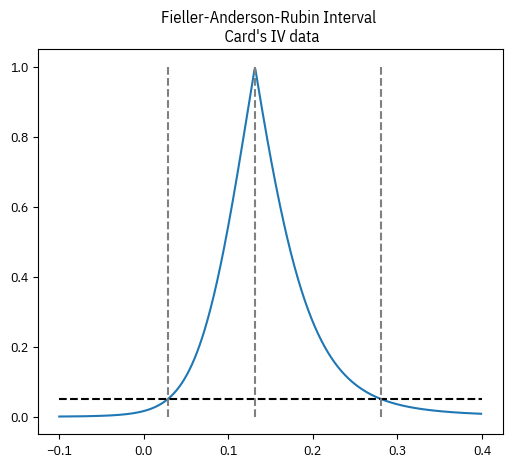

In [94]:
from joblib import Parallel, delayed

CIrange = np.arange(-0.1, 0.4, 0.001)


def pvfun(t):
    Y_t = Y - t * D
    mod = sm.OLS(Y_t, np.c_[sm.add_constant(Z), X]).fit(cov_type="HC2")
    Tstat = mod.params[1] / mod.bse[1]
    return (1 - sp.stats.norm.cdf(np.abs(Tstat))) * 2


Pvalue = Parallel(n_jobs=-1)(delayed(pvfun)(t) for t in CIrange)
Pvalue = np.stack(Pvalue)
lb, ub = CIrange[Pvalue >= 0.05].min(), CIrange[Pvalue >= 0.05].max()

f, ax = plt.subplots(figsize=(6, 5))
ax.plot(CIrange, Pvalue)
ax.hlines(0.05, -0.1, 0.4, color="k", linestyle="--")
ax.vlines([lb, iv_est2, ub], 0, 1, color="grey", linestyle="--")
ax.set_title("Fieller-Anderson-Rubin Interval \n Card's IV data")
plt.show()

In [95]:
{
    "tsls": iv_est2,
    "lower CI": lb,
    "upper CI": ub,
}

{'tsls': 0.13150383624468942,
 'lower CI': 0.02900000000000011,
 'upper CI': 0.28100000000000036}

### bonus: control function

In [103]:
# one-shot estimate and SE
Dhat = sm.OLS(D, np.c_[sm.add_constant(Z), X]).fit().predict()
tslsreg = sm.OLS(Y, np.c_[sm.add_constant(D), D - Dhat, X]).fit(cov_type="HC1")
tslsreg.params[1], tslsreg.bse[1]

(0.13150383624469544, 0.05159083734463283)